# Analyzing the quadratic residuals

Successfully loaded 64495 secondary residual data points.

--- 2. ADF Stationarity Test ---
Test Statistic                -1.504494e+01
p-value                        9.474390e-28
#Lags Used                     5.200000e+01
Number of Observations Used    6.444200e+04
dtype: float64
✅ Residual series is likely **stationary** (p-value=0.0000). Can be used directly for LSTM.

--- 3. Plotting ACF/PACF for M8+3 Secondary Residuals (LGBM_Resid) ---


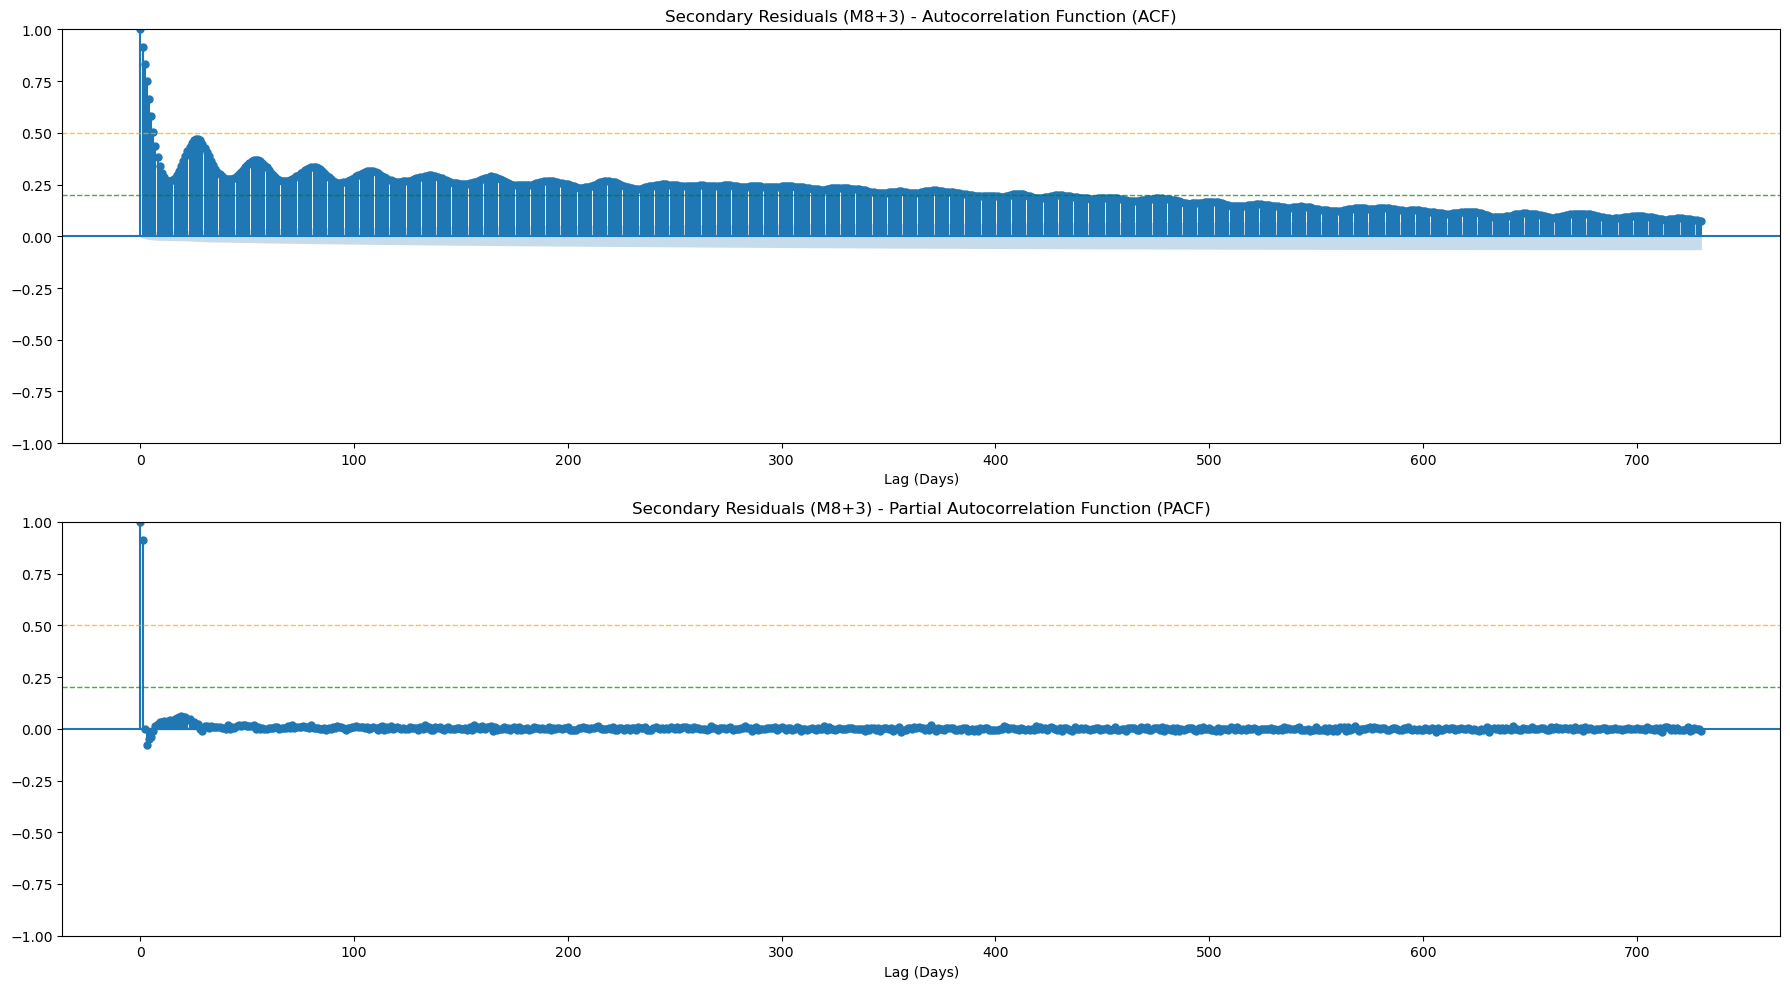


--- 4. Sequence Length (SEQUENCE_LENGTH) Suggestions ---
Please focus on significant peaks in the ACF plot at:
1. 7-30 days (Solar rotation cycle)
2. 154 days (Rieger cycle)
3. 365 days (Annual cycle)
and other significant positions.

The current SEQUENCE_LENGTH is set to 365 (365 days), which is a good starting point.
However, if the PACF shows strong peaks beyond this range, adjustments may be necessary.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

# --- Constant Definitions (Ensure these are defined at the top) ---
TARGET_SSN_COLUMN = 'Raw_SSN' # Assuming your original SSN data column name
DATA_FILE = "../../results/05_p_m_a_model/m_model_4/LGBM_results2.csv"
MODEL_TO_ANALYZE = 'M8+3' # Select the model with the highest R2 for analysis
RESID_COL = f'LGBM_Resid_{MODEL_TO_ANALYZE}' # Column name for secondary residuals
MAX_LAG = 730 # Max lag days (2 years, to observe annual cycles)
SEQUENCE_LENGTH = 365 # Missing constant, defined here for printing purposes

# --- 1. Load Data ---
try:
    data_full = pd.read_csv(DATA_FILE, parse_dates=['Date'])
    # Use only actual observations that have residuals
    resid_data = data_full[['Date', RESID_COL]].dropna()
    resid_series = resid_data[RESID_COL]
    print(f"Successfully loaded {len(resid_series)} secondary residual data points.")
except Exception as e:
    print(f"Fatal Error: Could not read {DATA_FILE}. Error: {e}")
    exit()

# --- 2. Stationarity Test (Augmented Dickey-Fuller Test) ---
# LSTM requires the input sequence to be stationary. 
# If residuals are non-stationary, differencing might be needed.
print("\n--- 2. ADF Stationarity Test ---")
adf_result = adfuller(resid_series, autolag='AIC')
adf_output = pd.Series(adf_result[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
print(adf_output)

if adf_output['p-value'] < 0.05:
    print(f"✅ Residual series is likely **stationary** (p-value={adf_output['p-value']:.4f}). Can be used directly for LSTM.")
else:
    print(f"⚠️ Residual series is likely **non-stationary** (p-value={adf_output['p-value']:.4f}). Further differencing might be needed before LSTM training.")


# --- 3. Plot ACF and PACF ---
print(f"\n--- 3. Plotting ACF/PACF for {MODEL_TO_ANALYZE} Secondary Residuals (LGBM_Resid) ---")

fig, axes = plt.subplots(2, 1, figsize=(18, 10))

# ACF (Autocorrelation Function)
plot_acf(resid_series, lags=MAX_LAG, ax=axes[0], title=f'Secondary Residuals ({MODEL_TO_ANALYZE}) - Autocorrelation Function (ACF)')
axes[0].set_xlabel('Lag (Days)')
axes[0].axhline(0.5, color='orange', linestyle='--', linewidth=1, alpha=0.7) # Mark 0.5 correlation
axes[0].axhline(0.2, color='green', linestyle='--', linewidth=1, alpha=0.7) # Mark 0.2 correlation

# PACF (Partial Autocorrelation Function)
plot_pacf(resid_series, lags=MAX_LAG, ax=axes[1], title=f'Secondary Residuals ({MODEL_TO_ANALYZE}) - Partial Autocorrelation Function (PACF)', method='ywm')
axes[1].set_xlabel('Lag (Days)')
axes[1].axhline(0.5, color='orange', linestyle='--', linewidth=1, alpha=0.7)
axes[1].axhline(0.2, color='green', linestyle='--', linewidth=1, alpha=0.7)

plt.tight_layout()
plt.show()

# --- 4. Result Interpretation ---
print("\n--- 4. Sequence Length (SEQUENCE_LENGTH) Suggestions ---")
print("Please focus on significant peaks in the ACF plot at:")
print("1. 7-30 days (Solar rotation cycle)")
print("2. 154 days (Rieger cycle)")
print("3. 365 days (Annual cycle)")
print("and other significant positions.")
print(f"\nThe current SEQUENCE_LENGTH is set to {SEQUENCE_LENGTH} ({SEQUENCE_LENGTH} days), which is a good starting point.") 
print("However, if the PACF shows strong peaks beyond this range, adjustments may be necessary.")

# LSTM

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
import time
import warnings

# Ensure reproducibility
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

warnings.filterwarnings('ignore')

# Check TensorFlow and GPU
print(f"TensorFlow Version: {tf.__version__}")
if tf.config.list_physical_devices('GPU'):
    print("GPU is available for TensorFlow.")
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        try:
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
        except RuntimeError as e:
            print(e)
else:
    print("WARNING: GPU not found. Training might be slow.")

# --- Constants Definition ---
TARGET_SSN_COLUMN = 'Raw_SSN'  # Updated target column name
DATA_FILE = "../../results/05_p_m_a_model/m_model_4/LGBM_results2.csv"
# Columns expected: ['Date', 'Raw_SSN', 'Smoothed_SSN', 'SIDC_SSN', 'Fit_SSN_M8+2', 'Residual_M8+2', ...]

TRAIN_START_DATE = '1855-12-02'
TEST_END_DATE = '2019-11-30'
FUTURE_KNOWN_END_DATE = '2025-07-31'
SEQUENCE_LENGTH = 400

# --- Helper: Create Time Series Sequences (Unchanged) ---
def create_sequences(data, seq_length):
    X, Y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:(i + seq_length)])
        Y.append(data[i + seq_length])
    return np.array(X), np.array(Y)

# --- Core: Define LSTM Model (Unchanged) ---
def build_lstm_model(seq_length):
    model = Sequential([
        LSTM(128, input_shape=(seq_length, 1), return_sequences=False),
        Dense(64, activation='relu'),
        Dense(1)
    ])
    
    model.compile(
        optimizer=Adam(learning_rate=1e-3),
        loss='mae'
    )
    return model

# --- Helper: Calculate R2 for a Segment ---
def _calculate_r2_segment(segment_df, pf_col_orig, lgbm_pred_col_orig, total_pred_col, target_col):
    """
    Calculate three comprehensive R2 scores for a single data segment.
    """
    if segment_df.empty:
        return np.nan, np.nan, np.nan
        
    y_true = segment_df[target_col].values
    
    # 1. Planetary Fit Only
    y_pred_planetary = segment_df[pf_col_orig].values
    r2_planetary = r2_score(y_true, y_pred_planetary)

    # 2. Planetary + LGBM 
    y_pred_planetary_lgbm = segment_df[pf_col_orig] + segment_df[lgbm_pred_col_orig]
    r2_planetary_lgbm = r2_score(y_true, y_pred_planetary_lgbm)
    
    # 3. Total Prediction (Planetary + LGBM + LSTM)
    y_pred_total = segment_df[total_pred_col]
    r2_planetary_lgbm_lstm = r2_score(y_true, y_pred_total)
    
    return r2_planetary, r2_planetary_lgbm, r2_planetary_lgbm_lstm

# --- Comprehensive R2 Calculation (Segmented) ---
def calculate_comprehensive_r2(data_full, model_name, run_stats, split_date):
    """
    Calculate segmented comprehensive R2 for Train, Test, and Future sets.
    """
    
    # Original Column Names (Updated to English)
    planetary_fit_col_orig = f'Fit_SSN_{model_name}'
    lgbm_pred_col_orig = f'LGBM_Pred_{model_name}'
    total_pred_col = f'Total_Pred_{model_name}'
    
    # Check required columns
    required_cols = [TARGET_SSN_COLUMN, planetary_fit_col_orig, lgbm_pred_col_orig, total_pred_col]
    
    if any(col not in data_full.columns for col in required_cols):
        missing = [col for col in required_cols if col not in data_full.columns]
        print(f"⚠️ WARNING: Comprehensive R2 failed for {model_name}. Missing columns: {missing}.")
        return run_stats

    # 1. Define Date Masks
    train_end_dt = pd.to_datetime(split_date)
    test_end_dt = pd.to_datetime(TEST_END_DATE)
    future_end_dt = pd.to_datetime(FUTURE_KNOWN_END_DATE)

    # Use only rows where required columns are not NaN
    calc_df = data_full.dropna(subset=required_cols).copy()
    
    # Ensure Date column is datetime
    calc_df['Date'] = pd.to_datetime(calc_df['Date'])
    
    train_mask = calc_df['Date'] <= train_end_dt
    test_mask = (calc_df['Date'] > train_end_dt) & (calc_df['Date'] <= test_end_dt)
    future_mask = (calc_df['Date'] > test_end_dt) & (calc_df['Date'] <= future_end_dt)

    # 2. Segment Data
    train_segment = calc_df[train_mask]
    test_segment = calc_df[test_mask]
    future_segment = calc_df[future_mask]

    enhanced_stats = run_stats.copy()

    # 3. Loop to calculate R2
    segments = {'Train': train_segment, 'Test': test_segment, 'Future': future_segment}
    
    for prefix, segment in segments.items():
        r2_p, r2_pl, r2_plt = _calculate_r2_segment(
            segment, planetary_fit_col_orig, lgbm_pred_col_orig, total_pred_col, TARGET_SSN_COLUMN
        )
        
        enhanced_stats.update({
            f'R2_1_Planetary_vs_SSN_{prefix}': r2_p,
            f'R2_2_Planetary_LGBM_vs_SSN_{prefix}': r2_pl,
            f'R2_3_Planetary_LGBM_LSTM_vs_SSN_{prefix}': r2_plt,
        })
        
    # Keep original LSTM vs Residual R2 with clear naming
    enhanced_stats['R2_4_LSTM_vs_Residual_Test'] = run_stats['r2_test'] 
    
    return enhanced_stats

# --- Save Detailed Results ---
def save_detailed_results(final_data, stats_list, seq_length):
    """
    Save detailed CSV results and print R2 statistical summary.
    """
    timestamp = time.strftime("%Y%m%d_%H%M%S")
    
    # 1. Save Full Data CSV
    data_filename = f"../../results/05_p_m_a_model/a_model_4/LSTM_Full_Results_SEQLEN{seq_length}_{timestamp}.csv"
    try:
        # Exclude individual run columns to keep file size manageable if needed, 
        # or keep them. Logic here keeps everything except intermediate LSTM preds if desired.
        # For now, saving relevant columns.
        cols_to_save = [col for col in final_data.columns if not (col.startswith('LSTM_Pred_M') and col[-1].isdigit())]
        final_data[cols_to_save].to_csv(data_filename, index=False, encoding='utf-8-sig')
        print(f"✅ Full data saved to: {data_filename}")
    except Exception as e:
        print(f"❌ Failed to save data CSV: {e}")
    
    # 2. Save Statistics CSV
    if stats_list and any('R2_1_Planetary_vs_SSN_Test' in stat for stat in stats_list):
        stats_df = pd.DataFrame(stats_list)
        stats_filename = f"LSTM_R2_Stats_SEQLEN{seq_length}_{timestamp}.csv"
        
        # Define column order
        stat_columns = ['model', 'run', 
                        'R2_3_Planetary_LGBM_LSTM_vs_SSN_Test', 'R2_3_Planetary_LGBM_LSTM_vs_SSN_Train', 'R2_3_Planetary_LGBM_LSTM_vs_SSN_Future', 
                        'R2_4_LSTM_vs_Residual_Test', 
                        'r2_train', 'r2_test', 'r2_future_known', 'time']
        
        # Add all segmented R2 columns
        all_r2_cols = [col for col in stats_df.columns if col.startswith('R2_') and col not in stat_columns]
        stat_columns = stat_columns[:4] + sorted(all_r2_cols) + stat_columns[4:]
        stat_columns = list(dict.fromkeys(stat_columns)) # Deduplicate

        available_columns = [col for col in stat_columns if col in stats_df.columns]
        stats_df[available_columns].to_csv(stats_filename, index=False, encoding='utf-8-sig')
        print(f"✅ R2 Statistics saved to: {stats_filename}")
        
        # Print Summary
        print("\n" + "="*120)
        print(f"Segmented R2 Evaluation Summary (Test Set R2 is the primary generalization metric)")
        print("="*120)
        
        summary_cols = ['R2_3_Planetary_LGBM_LSTM_vs_SSN_Train', 
                        'R2_3_Planetary_LGBM_LSTM_vs_SSN_Test', 
                        'R2_3_Planetary_LGBM_LSTM_vs_SSN_Future', 
                        'R2_4_LSTM_vs_Residual_Test']
        
        available_summary_cols = [col for col in summary_cols if col in stats_df.columns]
        if available_summary_cols:
            summary_df = stats_df.groupby('model')[available_summary_cols].mean().reset_index()
            summary_df = summary_df.rename(columns={
                'R2_3_Planetary_LGBM_LSTM_vs_SSN_Train': 'R2(Total)-Train',
                'R2_3_Planetary_LGBM_LSTM_vs_SSN_Test': 'R2(Total)-Test',
                'R2_3_Planetary_LGBM_LSTM_vs_SSN_Future': 'R2(Total)-Future',
                'R2_4_LSTM_vs_Residual_Test': 'R2(LSTM vs Resid)-Test'
            })
            print(summary_df.round(4).to_string(index=False))
            
            # Print Detailed Progressive Analysis
            print("\n--- Test Set R2 Progressive Analysis ---")
            detail_cols = ['R2_1_Planetary_vs_SSN_Test', 
                           'R2_2_Planetary_LGBM_vs_SSN_Test', 
                           'R2_3_Planetary_LGBM_LSTM_vs_SSN_Test']
            
            detail_summary = stats_df.groupby('model')[detail_cols].mean().reset_index()
            detail_summary = detail_summary.rename(columns={
                'R2_1_Planetary_vs_SSN_Test': 'R2(Planetary)',
                'R2_2_Planetary_LGBM_vs_SSN_Test': 'R2(Planetary+LGBM)',
                'R2_3_Planetary_LGBM_LSTM_vs_SSN_Test': 'R2(Total)'
            })
            print(detail_summary.round(4).to_string(index=False))

    elif stats_list:
        print("\n⚠️ Statistics summary skipped: All comprehensive R2 calculations failed.")
        
# --- Core: Main Running Function ---
def run_lstm_forecasting(data_full, model_name, split_date, num_runs=3):
    
    print(f"\n{'='*60}")
    print(f"🚀 Processing Model: {model_name} (LGBM Secondary Residual, SEQ_LEN={SEQUENCE_LENGTH})")
    print(f"{'='*60}")

    # Define Column Names
    lgbm_pred_col_orig = f'LGBM_Pred_{model_name}'
    lgbm_resid_col = f'LGBM_Resid_{model_name}' 
    planetary_fit_col_orig = f'Fit_SSN_{model_name}' # Updated
    
    # Check Critical Columns
    if TARGET_SSN_COLUMN not in data_full.columns or lgbm_resid_col not in data_full.columns or planetary_fit_col_orig not in data_full.columns:
        print(f"❌ Error: Missing columns {TARGET_SSN_COLUMN}, {lgbm_resid_col}, or {planetary_fit_col_orig}.")
        return None, None

    # --- 1. Data Preparation & Split ---
    resid_data = data_full[['Date', lgbm_resid_col]].dropna()
    dates = resid_data['Date']
    resid_values = resid_data[lgbm_resid_col].values.reshape(-1, 1)

    train_end_dt = pd.to_datetime(split_date)
    test_start_dt = train_end_dt + pd.Timedelta(days=1)
    
    train_mask = dates <= train_end_dt
    
    # --- 2. Scaling ---
    scaler = StandardScaler()
    scaler.fit(resid_values[train_mask])
    resid_scaled = scaler.transform(resid_values)
    
    # Create Sequences (X) and Targets (Y)
    X_full, Y_full = create_sequences(resid_scaled, SEQUENCE_LENGTH)
    dates_full_seq = dates.iloc[SEQUENCE_LENGTH:].reset_index(drop=True)

    # Resplit Sequences
    train_seq_mask = (dates_full_seq <= train_end_dt)
    test_seq_mask = (dates_full_seq >= test_start_dt) & (dates_full_seq <= pd.to_datetime(TEST_END_DATE))
    future_seq_mask = (dates_full_seq > pd.to_datetime(TEST_END_DATE)) & (dates_full_seq <= pd.to_datetime(FUTURE_KNOWN_END_DATE))

    X_train = X_full[train_seq_mask]
    Y_train = Y_full[train_seq_mask]
    X_test = X_full[test_seq_mask]
    Y_test = Y_full[test_seq_mask]
    X_future_known = X_full[future_seq_mask]
    Y_future_known = Y_full[future_seq_mask] 

    print(f"Train Sequence Length: {len(X_train)} (Until {split_date})")
    print(f"Test Sequence Length: {len(X_test)} (From {test_start_dt.date()} to {TEST_END_DATE})")
    print(f"Future Known Sequence Length: {len(X_future_known)} (From 2019-12-01 to {FUTURE_KNOWN_END_DATE})")

    # --- 3. Multiple Fitting & Prediction ---
    all_results = []
    pred_col_name = f'LSTM_Pred_{model_name}'
    
    data_with_lstm_preds = data_full.copy()
    
    for run in range(1, num_runs + 1):
        start_time = time.time()
        
        tf.keras.backend.clear_session()
        tf.random.set_seed(run) 
        np.random.seed(run)
        
        lstm_model = build_lstm_model(SEQUENCE_LENGTH)
        
        print(f"\n--- Run {run} Start ---")
        
        history = lstm_model.fit(
            X_train, Y_train,
            epochs=30,
            batch_size=256,
            validation_data=(X_test, Y_test),
            callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)],
            verbose=0 
        )
        
        Y_pred_full_scaled = lstm_model.predict(X_full, verbose=0)
        Y_pred_full_raw = scaler.inverse_transform(Y_pred_full_scaled).flatten()
        
        temp_df = pd.DataFrame({
            'Date': dates_full_seq,
            f'{pred_col_name}_{run}': Y_pred_full_raw
        })
        
        data_with_lstm_preds = pd.merge(data_with_lstm_preds, temp_df, on='Date', how='left')

        # --- 4. Evaluation (LSTM vs Residual) ---
        Y_pred_train = Y_pred_full_raw[train_seq_mask]
        Y_pred_test = Y_pred_full_raw[test_seq_mask]
        Y_pred_future_known = Y_pred_full_raw[future_seq_mask]
        
        resid_values_seq = resid_data[lgbm_resid_col].iloc[SEQUENCE_LENGTH:].values
        Y_actual_train = resid_values_seq[train_seq_mask]
        Y_actual_test = resid_values_seq[test_seq_mask]
        Y_actual_future_known = resid_values_seq[future_seq_mask]
        
        r2_train = r2_score(Y_actual_train, Y_pred_train)
        r2_test = r2_score(Y_actual_test, Y_pred_test)
        r2_future_known = r2_score(Y_actual_future_known, Y_pred_future_known)
        
        result = {
            'model': model_name,
            'run': run,
            'r2_train': r2_train,
            'r2_test': r2_test,
            'r2_future_known': r2_future_known,
            'time': time.time() - start_time
        }
        all_results.append(result)
        
        print(f"R2 (Train): {r2_train:.4f} | R2 (Test): {r2_test:.4f} | R2 (2019-2025): {r2_future_known:.4f} | Time: {result['time']:.2f}s")

    # --- 5. Calculate Final Total Prediction ---
    lstm_cols = [f'{pred_col_name}_{r}' for r in range(1, num_runs + 1)]
    lstm_mean_pred_col = f'LSTM_Mean_Pred_{model_name}'
    total_pred_col = f'Total_Pred_{model_name}'

    data_with_lstm_preds[lstm_mean_pred_col] = data_with_lstm_preds[lstm_cols].mean(axis=1)
    
    data_with_lstm_preds[total_pred_col] = (
        data_with_lstm_preds[planetary_fit_col_orig] + 
        data_with_lstm_preds.get(lgbm_pred_col_orig, 0) + 
        data_with_lstm_preds.get(lstm_mean_pred_col, 0)
    )

    # 1. Fallback: P + L
    planetary_lgbm_sum = (
        data_with_lstm_preds[planetary_fit_col_orig] + 
        data_with_lstm_preds.get(lgbm_pred_col_orig, 0)
    )
    
    # 2. Fill NaNs in Total Pred with P + L
    data_with_lstm_preds[total_pred_col] = data_with_lstm_preds[total_pred_col].fillna(planetary_lgbm_sum)
    
    # 3. Fill remaining NaNs with P only
    data_with_lstm_preds[total_pred_col] = data_with_lstm_preds[total_pred_col].fillna(data_with_lstm_preds[planetary_fit_col_orig])
    return data_with_lstm_preds, all_results


# --- Main Execution ---
if __name__ == "__main__":
    
    pd.set_option('display.max_rows', None)
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', 1000)

    model_splits = {
        'M8+2': '1996-08-01',
        'M8+3': '1986-08-01',
        'M0+3': '1986-09-01',
        'M0+2': '1996-08-01'
    }

    # 1. Load Data
    try:
        data_full = pd.read_csv(DATA_FILE, parse_dates=['Date'])
        data_full['Date'] = pd.to_datetime(data_full['Date']) 
        
        # Check target column
        if TARGET_SSN_COLUMN not in data_full.columns:
            print(f"WARNING: Column {TARGET_SSN_COLUMN} missing. Creating dummy column for demonstration.")
            if 'Fit_SSN_M8+3' in data_full.columns and 'Residual_M8+3' in data_full.columns:
                data_full[TARGET_SSN_COLUMN] = data_full['Fit_SSN_M8+3'] + data_full['Residual_M8+3']
                data_full[TARGET_SSN_COLUMN] = data_full[TARGET_SSN_COLUMN].interpolate(method='linear')
            else:
                 print(f"FATAL ERROR: Missing {TARGET_SSN_COLUMN} and base columns to recreate it.")
                 exit()
    except Exception as e:
        print(f"FATAL ERROR: Could not read {DATA_FILE}. Error: {e}")
        exit()
        
    all_stats_list = []
    final_output_df = data_full.copy() 

    # 2. Process each model
    for model_name, split_date in model_splits.items():
        
        # Run LSTM Forecasting
        result_df_full, stats_list = run_lstm_forecasting(
            data_full=data_full.copy(), 
            model_name=model_name,
            split_date=split_date,
            num_runs=3
        )

        if result_df_full is not None and stats_list is not None:
            
            # Extract new columns
            new_cols = [col for col in result_df_full.columns if col.startswith(('LSTM_Mean_Pred_', 'Total_Pred_', 'LSTM_Pred_')) or col == 'Date']
            
            # Merge
            final_output_df = pd.merge(final_output_df, result_df_full[new_cols], on='Date', how='left')
            
            # Calculate Comprehensive R2
            enhanced_stats_list = []
            for stats in stats_list:
                enhanced_stats = calculate_comprehensive_r2(
                    final_output_df, model_name, stats, split_date
                )
                enhanced_stats_list.append(enhanced_stats)
            
            all_stats_list.extend(enhanced_stats_list)

    # 3. Prepare Final Data
    final_data_for_save = final_output_df.copy()

    # 4. Save and Summarize
    save_detailed_results(final_data_for_save, all_stats_list, SEQUENCE_LENGTH)
    
    print("\n✅ Process completed. All results saved to CSV.")

2025-12-29 22:03:36.285199: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-29 22:03:36.331143: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1767017016.341296   12185 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1767017016.345591   12185 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1767017016.384237   12185 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

TensorFlow Version: 2.19.1
GPU is available for TensorFlow.

🚀 Processing Model: M8+2 (LGBM Secondary Residual, SEQ_LEN=400)
Train Sequence Length: 53504 (Until 1996-08-01)
Test Sequence Length: 8521 (From 1996-08-02 to 2019-11-30)
Future Known Sequence Length: 2070 (From 2019-12-01 to 2025-07-31)


I0000 00:00:1767017018.017361   12185 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22136 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:01:00.0, compute capability: 8.9



--- Run 1 Start ---


I0000 00:00:1767017019.073147   12418 cuda_dnn.cc:529] Loaded cuDNN version 91002


R2 (Train): 0.8130 | R2 (Test): 0.9232 | R2 (2019-2025): 0.8719 | Time: 39.07s

--- Run 2 Start ---
R2 (Train): 0.8131 | R2 (Test): 0.9245 | R2 (2019-2025): 0.8718 | Time: 31.35s

--- Run 3 Start ---
R2 (Train): 0.8121 | R2 (Test): 0.9227 | R2 (2019-2025): 0.8737 | Time: 26.87s

🚀 Processing Model: M8+3 (LGBM Secondary Residual, SEQ_LEN=400)
Train Sequence Length: 49851 (Until 1986-08-01)
Test Sequence Length: 12174 (From 1986-08-02 to 2019-11-30)
Future Known Sequence Length: 2070 (From 2019-12-01 to 2025-07-31)

--- Run 1 Start ---
R2 (Train): 0.8101 | R2 (Test): 0.9318 | R2 (2019-2025): 0.8629 | Time: 28.48s

--- Run 2 Start ---
R2 (Train): 0.8113 | R2 (Test): 0.9304 | R2 (2019-2025): 0.8627 | Time: 41.82s

--- Run 3 Start ---
R2 (Train): 0.8096 | R2 (Test): 0.9291 | R2 (2019-2025): 0.8627 | Time: 26.27s

🚀 Processing Model: M0+3 (LGBM Secondary Residual, SEQ_LEN=400)
Train Sequence Length: 49882 (Until 1986-09-01)
Test Sequence Length: 12143 (From 1986-09-02 to 2019-11-30)
Future K